### Library 

In [35]:
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt

sys.path.append('/home/antorosi/Documents/AutoEncoder/')

#from load_shape_data import conso_ds_to_array, plot_conso_day
from CVAE.cvae import compile_cvae, run_cvae
from CVAE.cvae_model import CVAE

from conso.conso_helpers import plot_latent_space_projection, conso_ds_to_array, plot_conso_day

In [2]:
path_data_folder = "/local/home/antorosi/Documents/AutoEncoder/data"

### Import data

In [3]:
conso_csv = os.path.join(path_data_folder, "conso_Y.csv")
conso_df = pd.read_csv(conso_csv, sep=";", engine='c', header=0)
conso_df['ds'] = pd.to_datetime(conso_df['date'] + ' ' + conso_df['time'])

In [4]:
holiday_days_csv = os.path.join(path_data_folder, "joursFeries.csv")
holiday_days_df = pd.read_csv(holiday_days_csv, sep=";")
holiday_days_df.ds = pd.to_datetime(holiday_days_df.ds)
holiday_days_df['is_hd'] = 1

In [5]:
# get only national observation
Xinput_ds = conso_df[['ds', 'Consommation NAT t0']].copy()

######  Get input array

In [6]:
X, ds = conso_ds_to_array(Xinput_ds)

In [15]:
calendar_info = pd.DataFrame(ds)
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, holiday_days_df[['ds', 'is_hd']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_hd'].isna(),'is_hd'] = 0

###### Get conditional variables 

In [16]:
# month
one_hot_month = pd.get_dummies(calendar_info.month, prefix='month')
# weekday
one_hot_weekday = pd.get_dummies(calendar_info.is_weekday, prefix = 'weekday')

In [17]:
# Getting the conditional array
cond = pd.concat([one_hot_month, one_hot_weekday], axis=1)
cond = cond.as_matrix()

In [8]:
#cond = one_hot_month.as_matrix()

In [9]:
#cond = np.zeros((cond.shape[0],1))

######  Get train and test

In [18]:
X_train = X[:-365,:] 
cond_train = cond[:-365,:]
calendar_info_train = calendar_info[:-365]
X_test = X[-365:,:]
cond_test = cond[-365:,:]
calendar_info_test = calendar_info[-365:]
calendar_info_test = calendar_info_test.reset_index(drop=True)

In [19]:
cond_train.sum(axis=0)

array([124, 113, 124, 120, 124, 101,  93,  93,  90,  93,  90,  97, 361,
       901], dtype=uint64)

###### Normalization

In [28]:
Min = X_train.min()
Max = X_train.max()

In [29]:
X_train = (X_train-Min)/(Max-Min)
X_test = (X_test-Min)/(Max-Min)

In [20]:
Mean = X_train.mean()
std = X_train.std()

In [21]:
X_train = (X_train-Mean)/(std)
X_test = (X_test-Mean)/(std)

In [22]:
X_train.shape

(1262, 96)

##### Saving data

In [23]:
dataset = {}

In [24]:
dataset['train'] = {'x': [X_train, cond_train], 'y': X_train}
dataset['test'] = {'x':  [X_test, cond_test], 'y': X_test}



### Building and Running model

In [45]:
output = '/home/antorosi/Documents/AutoEncoder/out'
name = 'cvae_conso_e24-12_d24-48_z6_norma-n'
model = CVAE(cond_dim = 14, e_dims=[48,24], d_dims=[24,48], z_dim=6, name = name, output = output)

complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 96)           0                                            
__________________________________________________________________________________________________
cond (InputLayer)               (None, 14)           0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 6), (None, 6 6804        x_true[0][0]                     
                                                                 cond[0][0]                       
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 6)            0           encoder[1][0]              



--- START TRAINING ---

Train on 1262 samples, validate on 365 samples
Epoch 1/200
1262/1262 [==============================] - 0s 232us/step - loss: 48.1861 - kl_loss: 7.2167 - recon_loss: 40.9694 - val_loss: 19.6469 - val_kl_loss: 5.7450 - val_recon_loss: 13.9019
Epoch 2/200
1262/1262 [==============================] - 0s 77us/step - loss: 14.1477 - kl_loss: 5.2820 - recon_loss: 8.8658 - val_loss: 17.8414 - val_kl_loss: 4.3525 - val_recon_loss: 13.4889
Epoch 3/200
1262/1262 [==============================] - 0s 78us/step - loss: 11.2692 - kl_loss: 4.6326 - recon_loss: 6.6366 - val_loss: 11.0163 - val_kl_loss: 4.9753 - val_recon_loss: 6.0410
Epoch 4/200
1262/1262 [==============================] - 0s 80us/step - loss: 9.7826 - kl_loss: 4.4318 - recon_loss: 5.3508 - val_loss: 9.4793 - val_kl_loss: 4.5706 - val_recon_loss: 4.9088
Epoch 5/200
1262/1262 [==============================] - 0s 77us/step - loss: 8.8863 - kl_loss: 4.2004 - recon_loss: 4.6859 - val_loss: 8.1926 - val_kl_loss:

1262/1262 [==============================] - 0s 78us/step - loss: 4.3911 - kl_loss: 2.2835 - recon_loss: 2.1076 - val_loss: 5.2368 - val_kl_loss: 2.5293 - val_recon_loss: 2.7075
Epoch 44/200
1262/1262 [==============================] - 0s 87us/step - loss: 4.3731 - kl_loss: 2.2579 - recon_loss: 2.1153 - val_loss: 4.9474 - val_kl_loss: 2.4732 - val_recon_loss: 2.4741
Epoch 45/200
1262/1262 [==============================] - 0s 82us/step - loss: 4.3805 - kl_loss: 2.2576 - recon_loss: 2.1229 - val_loss: 5.1006 - val_kl_loss: 2.2669 - val_recon_loss: 2.8336
Epoch 46/200
1262/1262 [==============================] - 0s 80us/step - loss: 4.2839 - kl_loss: 2.2092 - recon_loss: 2.0748 - val_loss: 4.5036 - val_kl_loss: 2.0791 - val_recon_loss: 2.4245
Epoch 47/200
1262/1262 [==============================] - 0s 83us/step - loss: 4.3146 - kl_loss: 2.1949 - recon_loss: 2.1197 - val_loss: 6.6788 - val_kl_loss: 2.6798 - val_recon_loss: 3.9990
Epoch 48/200
1262/1262 [==============================] - 

Epoch 86/200
1262/1262 [==============================] - 0s 79us/step - loss: 3.6402 - kl_loss: 1.7077 - recon_loss: 1.9324 - val_loss: 5.7252 - val_kl_loss: 2.2877 - val_recon_loss: 3.4375
Epoch 87/200
1262/1262 [==============================] - 0s 79us/step - loss: 3.6714 - kl_loss: 1.7983 - recon_loss: 1.8731 - val_loss: 3.8660 - val_kl_loss: 1.7422 - val_recon_loss: 2.1239
Epoch 88/200
1262/1262 [==============================] - 0s 76us/step - loss: 3.6739 - kl_loss: 1.7686 - recon_loss: 1.9053 - val_loss: 4.0552 - val_kl_loss: 2.0363 - val_recon_loss: 2.0189
Epoch 89/200
1262/1262 [==============================] - 0s 78us/step - loss: 3.6419 - kl_loss: 1.7592 - recon_loss: 1.8827 - val_loss: 4.5117 - val_kl_loss: 1.6519 - val_recon_loss: 2.8598
Epoch 90/200
1262/1262 [==============================] - 0s 79us/step - loss: 3.5205 - kl_loss: 1.6451 - recon_loss: 1.8753 - val_loss: 6.0505 - val_kl_loss: 1.7665 - val_recon_loss: 4.2840
Epoch 91/200
1262/1262 [=====================

Epoch 129/200
1262/1262 [==============================] - 0s 83us/step - loss: 3.2978 - kl_loss: 1.5522 - recon_loss: 1.7455 - val_loss: 4.9403 - val_kl_loss: 1.8534 - val_recon_loss: 3.0868
Epoch 130/200
1262/1262 [==============================] - 0s 81us/step - loss: 3.4151 - kl_loss: 1.5803 - recon_loss: 1.8348 - val_loss: 3.9865 - val_kl_loss: 1.7926 - val_recon_loss: 2.1938
Epoch 131/200
1262/1262 [==============================] - 0s 80us/step - loss: 3.3906 - kl_loss: 1.5806 - recon_loss: 1.8100 - val_loss: 4.5291 - val_kl_loss: 1.7248 - val_recon_loss: 2.8043
Epoch 132/200
1262/1262 [==============================] - 0s 85us/step - loss: 3.3113 - kl_loss: 1.5151 - recon_loss: 1.7962 - val_loss: 3.4313 - val_kl_loss: 1.6134 - val_recon_loss: 1.8179
Epoch 133/200
1262/1262 [==============================] - 0s 82us/step - loss: 3.3546 - kl_loss: 1.5498 - recon_loss: 1.8049 - val_loss: 3.6002 - val_kl_loss: 1.6422 - val_recon_loss: 1.9580
Epoch 134/200
1262/1262 [===============

Epoch 172/200
1262/1262 [==============================] - 0s 76us/step - loss: 3.2345 - kl_loss: 1.4810 - recon_loss: 1.7535 - val_loss: 5.3186 - val_kl_loss: 1.5850 - val_recon_loss: 3.7336
Epoch 173/200
1262/1262 [==============================] - 0s 75us/step - loss: 3.2350 - kl_loss: 1.5211 - recon_loss: 1.7139 - val_loss: 4.0459 - val_kl_loss: 1.5489 - val_recon_loss: 2.4971
Epoch 174/200
1262/1262 [==============================] - 0s 85us/step - loss: 3.2292 - kl_loss: 1.4756 - recon_loss: 1.7536 - val_loss: 3.7629 - val_kl_loss: 1.6322 - val_recon_loss: 2.1307
Epoch 175/200
1262/1262 [==============================] - 0s 80us/step - loss: 3.2494 - kl_loss: 1.5134 - recon_loss: 1.7360 - val_loss: 4.0814 - val_kl_loss: 1.5730 - val_recon_loss: 2.5084
Epoch 176/200
1262/1262 [==============================] - 0s 77us/step - loss: 3.1946 - kl_loss: 1.4956 - recon_loss: 1.6991 - val_loss: 3.4352 - val_kl_loss: 1.4966 - val_recon_loss: 1.9386
Epoch 177/200
1262/1262 [===============

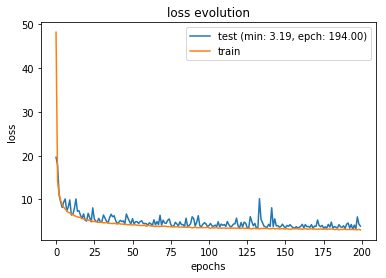

In [46]:
model.main_train(dataset, training_epochs=200, batch_size=20, verbose=True)

### Result analysis 

###### residuals  

In [47]:
z_hat = model.encoder.predict([X_test, cond_test])[0]
z_hat.shape

(365, 6)

In [79]:
cond_test.shape

(365, 14)

In [136]:
z_hat = model.encoder.predict([X_test, cond_test])[0]

X_hat = model.decoder.predict([z_hat, cond_test])

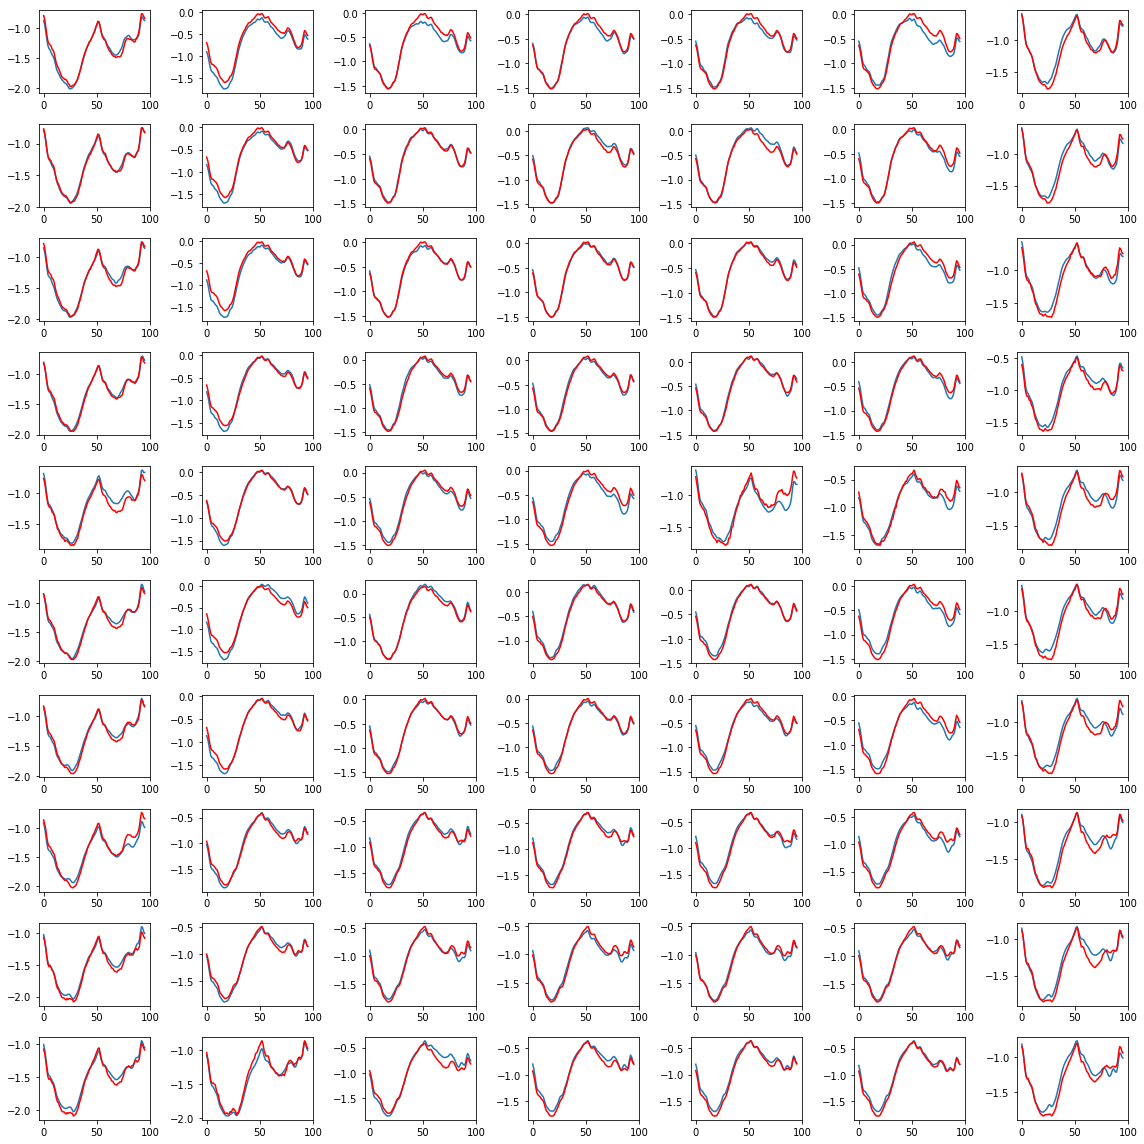

In [143]:
fig, axes = plt.subplots(10,7, figsize=(16,16))

ind = 0

for ax_row in axes:
    for ax in ax_row:
        # create a twin of the axis that shares the x-axis
        # plot some data on each axis.
        ax.plot(X_test[ind,:])
        ax.plot(X_hat[ind,:],'-r')
        
        ind+=1

plt.tight_layout()
plt.show()

In [138]:
residuals = (X_test - X_hat)
residuals_day = residuals.mean(axis=1)

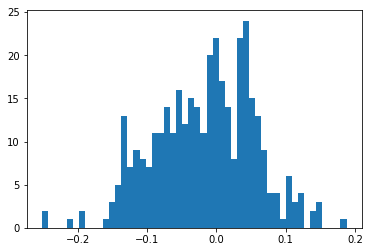

In [139]:
plt.hist(residuals_day, bins=50)
plt.show()

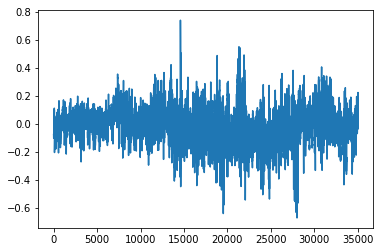

In [140]:
residuals = residuals.reshape(-1,1)
plt.plot(residuals)
plt.show()

###### Latent space projection 

In [121]:
x_encoded = model.encoder.predict([X_train, cond_train])[0]
calendar_info_plot = calendar_info_train

In [122]:
x_encoded.shape

(1262, 6)

In [123]:
from sklearn.manifold import TSNE

In [124]:
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=300)
x_encoded_2D = tsne.fit_transform(x_encoded)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1262 samples in 0.001s...
[t-SNE] Computed neighbors for 1262 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1262
[t-SNE] Computed conditional probabilities for sample 1262 / 1262
[t-SNE] Mean sigma: 0.064597
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.972454
[t-SNE] Error after 300 iterations: 0.711703


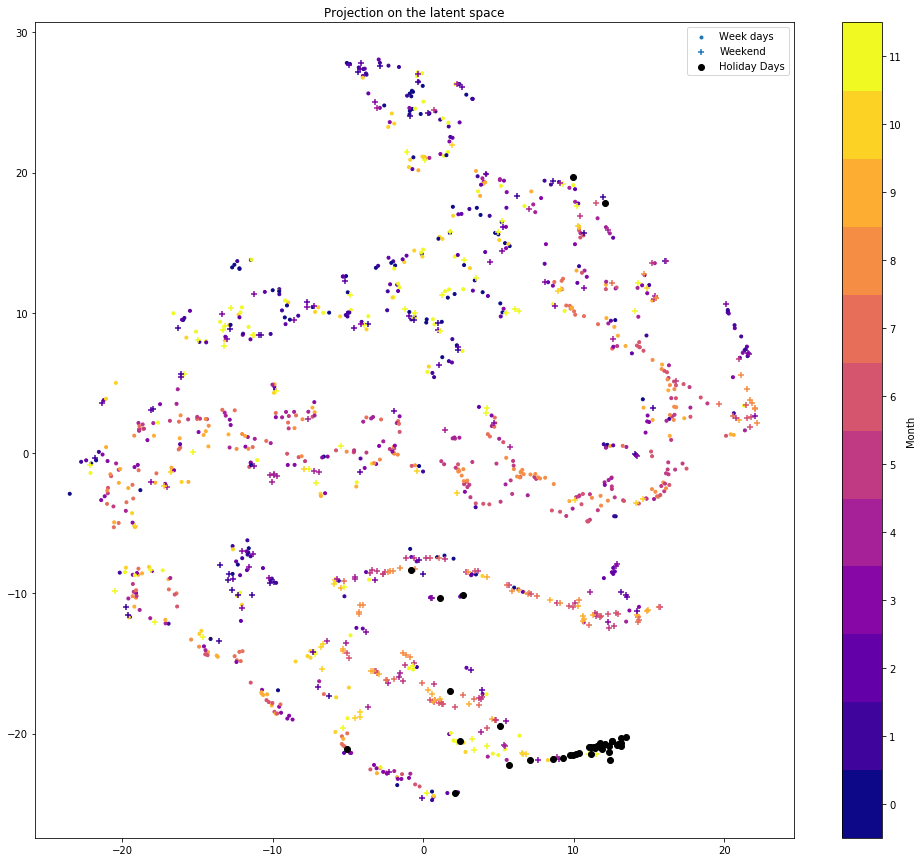

In [142]:
name_plot = 'latent_space_projection_train_tsne'
plot_latent_space_projection(x_proj=x_encoded_2D, calendar_info=calendar_info_plot,
                             path_folder_out=os.path.join(output,name,'results'), name=name_plot, 
                             pyplot=True, plotly = True)

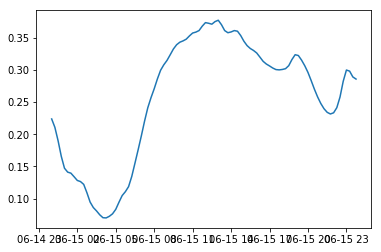

In [59]:
date = datetime.date(2015,6,15)
plot_conso_day(date,X_train,ds)